## Import and data split initiaion

In [47]:
import shutil
import sys
import os
import json
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
from ultralytics import YOLO
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from ultralytics import YOLO
import ultralytics
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import matplotlib.ticker as ticker
import warnings
import random
import seaborn as sns
import csv
import datetime

In [4]:
print(ultralytics.__version__)
# '8.3.134'
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
print(os.getcwd())

8.3.146
True
NVIDIA GeForce RTX 2080 SUPER
/home/ikuta_toma/Desktop/PBL5/PBL5


### Move splitted data back to the directory images

In [5]:
def move_back_img():
    for root, dirs, files in os.walk("./IP102/dataset"):
        for file in files:
            if file.lower().endswith('.jpg'):
                src_file_path = os.path.join(root, file)
                dst_file_path = os.path.join("IP102/ip102_v1.1/images/", file)
                shutil.move(src_file_path, dst_file_path)

In [6]:
move_back_flag = True # True => put data back

In [7]:
if move_back_flag:
    move_back_img()

## Create a look-up dictionary for label number and class noun.

In [8]:
with open("IP102/ip102_v1.1/num_label.txt") as f:
    num_to_label = {}
    for text in f.read().split("\n"):
        n,l = text.split(' ',1);
        num_to_label[n] = l.strip()

## Create empty classification directory to fit the YOLO dataset format

In [9]:
create_flag = False # True => create now

if create_flag == True:
    for label in num_to_label.values():
        train_class_dir = 'IP102/dataset/train/' + label
        val_class_dir = 'IP102/dataset/val/' + label
        test_class_dir = 'IP102/dataset/test/' + label
        os.mkdir(train_class_dir)
        os.mkdir(val_class_dir)
        os.mkdir(test_class_dir)

### make a table for converting from image to label number

In [10]:
"""
"IP102/ip102_v1.1/name_num_table.txt" has image name and label number
image name   (e.g.  xxxxx.jpg)
class number (e.g.          1)

name_to_num[:,0] => image names
name_to_num[:,1] => label numbers
"""

with open("IP102/ip102_v1.1/name_num_table.txt") as f:
    name_to_num = [] # class data
    for l in f.read().split("\n"):
        v = tuple(l.split())
        if v:
            v = [v[0],str(int(v[1])+1)] # to fit the format in num_to_label.txt
            name_to_num.append(v)

name_to_num = np.array(name_to_num)
label_list = list(set(name_to_num[:,0]))

### Move image to train/val/test

In [11]:
def move_img(train_val_test_pack):
    src_directory = "IP102/ip102_v1.1/images/"
    for split_type, name_num_dic in train_val_test_pack.items():
        for name, num in zip(name_num_dic["name"], name_num_dic["num"]):
            dst_directory = "IP102/dataset/{:s}/{:s}".format(split_type, num_to_label[num])
            shutil.move(src_directory + name, dst_directory)

## Parameter setup for k-fold cross validation

In [51]:
quick_demo_flag = True
methods = ['down_sampling', 'stratified']
method_selection = 'down_sampling'
down_sampling_size = 5 # size for each train, val, and test set in each fold 
stratified_size = 1/10 # reduced ratio
k = 2 # number of folds

## Reducing data size for testing

In [52]:
print("data size")
print("Whole: ", len(name_to_num))
if quick_demo_flag == True:
    if method_selection == 'down_sampling':
        # Downsampling method
        grouped = defaultdict(list)
        for name, num in zip(name_to_num[:,0],name_to_num[:,1]):
            grouped[num].append(name)
    
        min_size = min(len(names) for names in grouped.values())
        accept_min = np.floor(min_size/(3*k)) # 
    
        if (down_sampling_size > accept_min):
            print("down_sampling_size is bigger than accpetable size. Some classes cannot be distributed to train/val/test sets.")
            down_sampling_size = accept_min
            print("down_sampling_size is set to the minimun: ".format(down_sampling_size))
            
        random.seed(42)
        
        reduced_dataset_name = []
        reduced_dataset_num = []
        for num, names in grouped.items():
            reduced_dataset_name.extend(random.sample(names,down_sampling_size*3*k))
            reduced_dataset_num.extend([num]*down_sampling_size*3*k)
    
        final_name_to_num = np.array(list(zip(reduced_dataset_name,reduced_dataset_num)))

    elif method_selection == 'stratified':
        _, name_reduced_data, _, num_reduced_data = train_test_split(name_to_num[:,0], 
                                                                    name_to_num[:,1], 
                                                                    stratify=name_to_num[:,1],
                                                                    test_size=stratified_size,
                                                                    random_state=43)
        final_name_to_num = np.array(list(zip(name_reduced_data,num_reduced_data)))

    print("Reduced : ", len(final_name_to_num))
  
else:
    final_name_to_num = name_to_num.copy()

data size
Whole:  75222
Reduced :  3060


### plot classification imbalance

In [53]:
# Plot for whole data
def plot_class_dist(final_name_to_num, num_train, num_val, num_test, num_to_label, fold_count, save_dir):
    warnings.simplefilter('ignore')
    
    num_list = {
        "Whole":final_name_to_num[:,1],
        "Train":num_train,
        "Val":num_val,
        "Test":num_test
    }
    
    l = len(num_list)
    fig, ax= plt.subplots(2,2, figsize=(18, 10))
    
    
    for i, (set_type, num) in enumerate(num_list.items()):
        dataset_count = Counter([num_to_label[single_num] for single_num in num])
        dataset_count = sorted(dataset_count.items(), key=lambda item: item[1],reverse=True)
        class_names, count_values = zip(*dataset_count)
    
        x = np.floor(i/2).astype(int)
        y = i%2
    
        b_text = 20
        m_text = 20
        s_text = 5
        
        ax[x][y].bar(class_names, count_values)
        ax[x][y].set_title('{:s} Data on Fold {}'.format(set_type, fold_count), fontsize=b_text, fontweight='bold')
        ax[x][y].set_xlabel('Class Name', fontsize=m_text)
        ax[x][y].set_ylabel('Data Size', fontsize=m_text)
        ax[x][y].xaxis.set_tick_params(rotation=90)
    
    
        max_count = max(count_values)
    
        n = int(np.floor(np.log10(max_count)))
        step = 10**n
    
        ax[x][y].yaxis.set_major_locator(ticker.MultipleLocator(step))
        ax[x][y].set_xticklabels(ax[x][y].get_xticklabels(), fontsize=s_text)
        ax[x][y].set_yticklabels(ax[x][y].get_yticklabels(), fontsize=m_text)
    
        # y_ticks = list(ax[x][y].get_yticks())
        # max_count_float = float(max_count)
        
        # if not any(np.isclose(tick, max_count_float) for tick in y_ticks):
        #     y_ticks.append(max_count_float)
        #     y_ticks = sorted(y_ticks)
            
    
        # if max_count not in y_ticks:
        #     y_ticks.append(max_count)
        #     y_ticks = sorted(y_ticks)
        
        # ax[x][y].set_yticks(y_ticks)
        # ax[x][y].set_ylim(bottom =0)
    
        # labels = [str(int(tick)) if tick.is_integer() else f"{tick:.1f}" for tick in y_ticks]
        # ax[x][y].set_yticklabels(labels, fontsize=m_text)
        
    
        print("Number of Classes for {} Data: {}".format(set_type, len(class_names) ))
    
    fig.tight_layout(pad=3.0)
    fig.savefig('{}/class_dist_fold_{}.png'.format(save_dir, fold_count))
    plt.close(fig)

## YOLO training

In [54]:
def yolo_classify(fold_count, save_dir):
    model = YOLO("yolov8n-cls.pt")
    
    # Train model
    train_results = model.train(
        data=os.path.join(os.getcwd(), "IP102/dataset"),
        epochs=1,
        imgsz=640,
        device="cuda")

    
    # Validate
    metrics = model.val()
    
    # Path to test dataset
    test_dir = os.path.join(os.getcwd(), "IP102/dataset/test")
    
    y_true = []
    y_pred = []
    
    # Get class mapping
    class_names = model.names
    
    # Loop through test set
    for class_name in os.listdir(test_dir):
        class_path = os.path.join(test_dir, class_name)
        if not os.path.isdir(class_path):
            continue
    
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            results = model.predict(image_path, verbose=False)
            pred_idx = results[0].probs.top1
            pred_name = class_names[pred_idx]
            y_true.append(class_name)
            y_pred.append(pred_name)
    
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')
    
    print(f"\nEvaluation on Test Set:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")

    fold_evaluation = {"accuracy": acc,"precison":precision, "recall": recall, "f1-score":f1}
    keys = fold_evaluation.keys()
    rows = list(fold_evaluation.values())
    
    with open("{}/evaluation_fold_{}.csv".format(save_dir,fold_count), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(keys)
        writer.writerows([rows])


    with open("{}/yolov8_config.json".format(save_dir), "w") as f:
        json.dump(model.overrides, f, indent=4)

    true_pred = {"true":y_true, "pred":y_pred}
    return true_pred

## 5-fold cross validation by StratifiedKFold 

2025-05-30 13:58:54.119470
Number of Classes for Whole Data: 102
Number of Classes for Train Data: 102
Number of Classes for Val Data: 102
Number of Classes for Test Data: 102
Ultralytics 8.3.146 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7970MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov

train: Scanning /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train... 1147 i

train: New cache created: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 223.5±132.2 MB/s, size: 29.2 KB)


val: Scanning /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... 383 images

val: New cache created: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.4e-05, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/classify/train7
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/1      1.44G      4.661         11        640: 100%|██████████| 72/72 
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:0


                   all     0.0104     0.0783

1 epochs completed in 0.003 hours.
Optimizer stripped from runs/classify/train7/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train7/weights/best.pt, 3.2MB

Validating runs/classify/train7/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7970MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,565,542 parameters, 0 gradients, 3.4 GFLOPs
train: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train... found 1147 images in 102 classes ✅ 
val: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... found 383 images in 102 classes ✅ 
test: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/test... found 1530 images in 102 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:00<00:0


                   all     0.0104     0.0783
Speed: 0.6ms preprocess, 1.5ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train7
Ultralytics 8.3.146 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7970MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,565,542 parameters, 0 gradients, 3.4 GFLOPs
train: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train... found 1147 images in 102 classes ✅ 
val: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... found 383 images in 102 classes ✅ 
test: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/test... found 1530 images in 102 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 630.1±235.9 MB/s, size: 29.2 KB)


val: Scanning /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... 383 images
               classes   top1_acc   top5_acc: 100%|██████████| 24/24 [00:01<00:0


                   all     0.0104     0.0783
Speed: 0.7ms preprocess, 1.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train72

Evaluation on Test Set:
Accuracy : 0.0131
Precision: 0.0077
Recall   : 0.0131
F1 Score : 0.0074
Number of Classes for Whole Data: 102
Number of Classes for Train Data: 102
Number of Classes for Val Data: 102
Number of Classes for Test Data: 102
Ultralytics 8.3.146 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7970MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=1, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torc

train: Scanning /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train... 1147 i

train: New cache created: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 279.5±104.9 MB/s, size: 24.9 KB)


val: Scanning /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... 383 images

val: New cache created: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=9.4e-05, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/classify/train8
Starting training for 1 epochs...

      Epoch    GPU_mem       loss  Instances       Size


        1/1      1.44G      4.666         11        640: 100%|██████████| 72/72 
               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:01<00:0


                   all    0.00783     0.0548

1 epochs completed in 0.003 hours.
Optimizer stripped from runs/classify/train8/weights/last.pt, 3.2MB
Optimizer stripped from runs/classify/train8/weights/best.pt, 3.2MB

Validating runs/classify/train8/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7970MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,565,542 parameters, 0 gradients, 3.4 GFLOPs
train: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train... found 1147 images in 102 classes ✅ 
val: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... found 383 images in 102 classes ✅ 
test: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/test... found 1530 images in 102 classes ✅ 


               classes   top1_acc   top5_acc: 100%|██████████| 12/12 [00:00<00:0


                   all    0.00783     0.0548
Speed: 0.6ms preprocess, 1.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train8
Ultralytics 8.3.146 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (NVIDIA GeForce RTX 2080 SUPER, 7970MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,565,542 parameters, 0 gradients, 3.4 GFLOPs
train: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/train... found 1147 images in 102 classes ✅ 
val: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... found 383 images in 102 classes ✅ 
test: /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/test... found 1530 images in 102 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 938.1±770.9 MB/s, size: 24.9 KB)


val: Scanning /home/ikuta_toma/Desktop/PBL5/PBL5/IP102/dataset/val... 383 images
               classes   top1_acc   top5_acc: 100%|██████████| 24/24 [00:01<00:0


                   all    0.00783     0.0548
Speed: 1.2ms preprocess, 1.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/train82

Evaluation on Test Set:
Accuracy : 0.0150
Precision: 0.0049
Recall   : 0.0150
F1 Score : 0.0062

Evaluation on total 2 folds:
Accuracy : 0.0141
Precision: 0.0064
Recall   : 0.0141
F1 Score : 0.0068


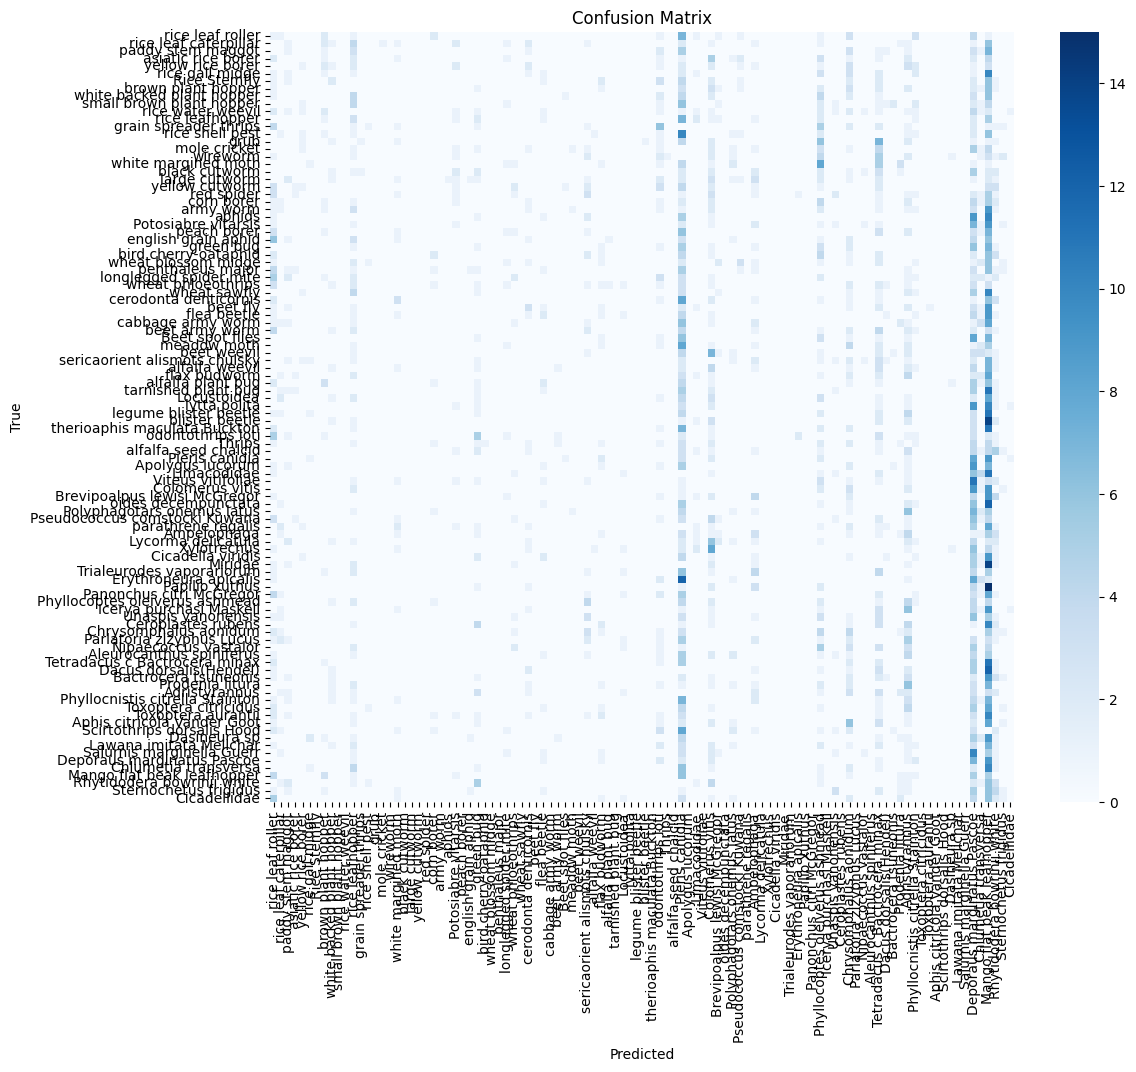

In [55]:
# train-val-test : 6-2-2

move_back_img()
skf = StratifiedKFold(n_splits=k)
fold_counter = 0;

all_y_true_pred = {"true":[], "pred":[]}

time = str(datetime.datetime.today())
save_dir = "result/{}".format(time)
os.mkdir(save_dir)
print(time)
for train_index, test_index in skf.split(final_name_to_num[:,0], final_name_to_num[:,1].astype(int)):
    fold_counter+=1
    test_dataset = np.array([final_name_to_num[i] for i in test_index])
    name_test, num_test = test_dataset[:,0], test_dataset[:,1]
    
    train_dataset = np.array([final_name_to_num[i] for i in train_index])
    name_train, name_val, num_train, num_val = train_test_split(train_dataset[:,0], 
                                                                    train_dataset[:,1], 
                                                                    stratify=train_dataset[:,1],
                                                                    test_size=0.25,
                                                                    random_state=43)
    train_val_test_pack = {
        "train": {"name":name_train,"num":num_train},
        "val":{"name":name_val,"num":num_val},
        "test":{"name":name_test,"num":num_test}
    }

    move_img(train_val_test_pack)
    plot_class_dist(final_name_to_num, num_train, num_val, num_test, num_to_label, fold_counter, save_dir)
    y_true_pred_dic = yolo_classify(fold_counter,save_dir)
    all_y_true_pred["true"].extend(y_true_pred_dic["true"])
    all_y_true_pred["pred"].extend(y_true_pred_dic["pred"])
    move_back_img()


acc = accuracy_score(all_y_true_pred["true"], all_y_true_pred["pred"])
precision, recall, f1, _ = precision_recall_fscore_support(all_y_true_pred["true"], all_y_true_pred["pred"], average='macro')

print("\nEvaluation on total {} folds:".format(k))
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

total_evaluation = {"accuracy": acc, "precison":precision, "recall": recall, "f1-score":f1}

keys = all_y_true_pred.keys()
rows = zip(*all_y_true_pred.values())

with open("{}/true_pred.csv".format(save_dir), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(keys)
    writer.writerows(rows)

keys = total_evaluation.keys()
rows = list(total_evaluation.values())

with open("{}/total_evaluation.csv".format(save_dir), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(keys)
    writer.writerows([rows])

all_y_true_pred["true"] = np.array(all_y_true_pred["true"]).flatten()
all_y_true_pred["pred"] = np.array(all_y_true_pred["pred"]).flatten()

labels = list(num_to_label.values())

cm = confusion_matrix(all_y_true_pred["true"], all_y_true_pred["pred"], labels=labels)
plt.figure(figsize=(12,10))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("{}/Confusion Matrix.png".format(save_dir))

In [38]:
path = "result/2025-05-30 12:41:31.119803/total_evaluation.csv"
with open(path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        print(row)

['precison', 'recall', 'f1-score']
['0.006392695329428223', '0.014052287581699347', '0.006769629780087658']
